<a href="https://colab.research.google.com/github/paramoza999/my_bot/blob/main/MINE_ASN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Required Installations
!pip install swig
!pip install gymnasium
!pip install mujoco
!pip install gymnasium[mujoco]
!pip install stable-baselines3[extra]
!pip install stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 18.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.2 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=19b5f4be12df7022c4fcf5d1450991f95436ece57bf3e8da14ed909740ea8bfe
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811


In [ ]:
#@title Check if installation was successful


import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [ ]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.8 MB/s eta 0:00:00


# CARTPOLE USING DQN AND PPO

In [ ]:
import gymnasium as gym
import stable_baselines3
import mujoco
%load_ext tensorboard

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


Streaming output truncated to the last 5000 lines.
|    learning_rate    | 0.0001   |
|    loss             | 0.0108   |
|    n_updates        | 4227     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.68     |
|    ep_rew_mean      | 9.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3920     |
|    fps              | 1919     |
|    time_elapsed     | 34       |
|    total_timesteps  | 66952    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0327   |
|    n_updates        | 4237     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.72     |
|    ep_rew_mean      | 9.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3924     |
|    fps              | 1917     |
|   

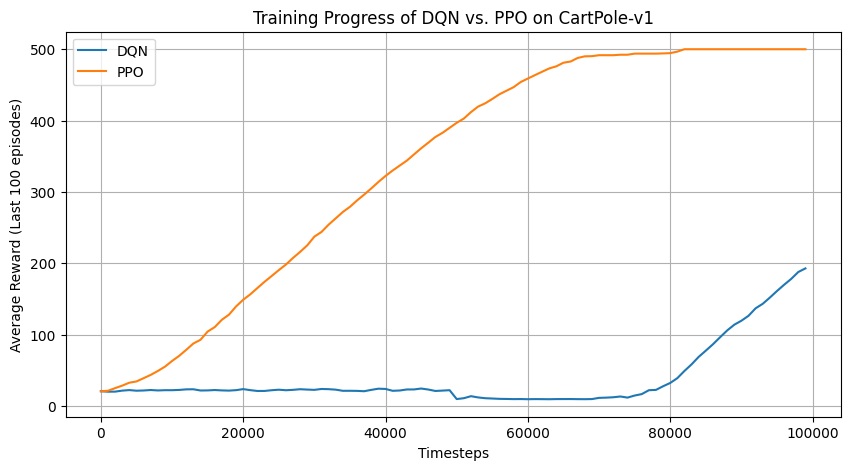

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

class RewardLogger(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(RewardLogger, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.rewards = []

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                mean_reward = np.mean(y[-100:])
                self.rewards.append(mean_reward)
        return True

log_dir_dqn = "/content/tensorboard_logs_dqn/"
log_dir_ppo = "/content/tensorboard_logs_ppo/"

env = gym.make('CartPole-v1', render_mode="rgb_array")

# Monitor wrappers to record stats
env_dqn = Monitor(env, log_dir_dqn)
env_ppo = Monitor(env, log_dir_ppo)

# Train DQN
model_dqn = DQN("MlpPolicy", env_dqn, verbose=1, tensorboard_log=log_dir_dqn)
callback_dqn = RewardLogger(check_freq=1000, log_dir=log_dir_dqn)
model_dqn.learn(total_timesteps=100000, callback=callback_dqn)
model_dqn.save('cart-dqn')
# Train PPO
model_ppo = PPO("MlpPolicy", env_ppo, verbose=1, tensorboard_log=log_dir_ppo)
callback_ppo = RewardLogger(check_freq=1000, log_dir=log_dir_ppo)
model_ppo.learn(total_timesteps=100000, callback=callback_ppo)
model_ppo.save('cart-ppo')



# PLOTTING AND VIDEO

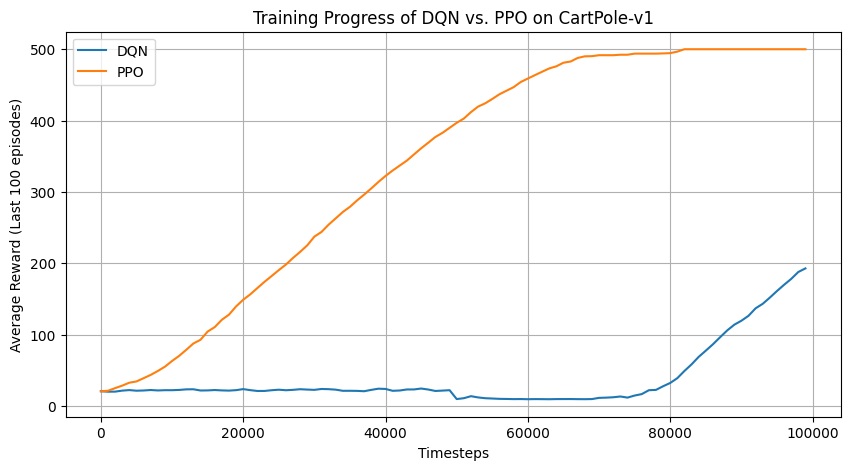

In [ ]:
# Plotting
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(callback_dqn.rewards)) * callback_dqn.check_freq, callback_dqn.rewards, label='DQN')
plt.plot(np.arange(len(callback_ppo.rewards)) * callback_ppo.check_freq, callback_ppo.rewards, label='PPO')
plt.xlabel('Timesteps')
plt.ylabel('Average Reward (Last 100 episodes)')
plt.title('Training Progress of DQN vs. PPO on CartPole-v1')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
obs,info = env.reset()
duration = 5  # seconds
framerate = 60  # FPS

frames = []
frames1 = []

for _ in range(duration * framerate):
    action, _states = model_dqn.predict(obs)
    obs, reward, terminated, truncated, info= env.step(action)
    frame = env.render()
    frames.append(frame)

    if terminated or truncated:
      observation, info = env.reset()

env.close()

for _ in range(duration * framerate):
    action, _states = model_ppo.predict(obs)
    obs, reward, terminated, truncated, info= env.step(action)
    frame = env.render()
    frames1.append(frame)

    if terminated or truncated:
      observation, info = env.reset()

env.close()

# Show the video of the trained agent
import mediapy as media


###USING DQN
media.show_video(frames, fps=60)


## USING PPO
media.show_video(frames1, fps=60)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## HUMANOID USING PPO

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3 import DDPG, SAC
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.her import HerReplayBuffer
from stable_baselines3.common.monitor import Monitor


env = gym.make('Humanoid-v4', render_mode="rgb_array")

class RewardLogger(BaseCallback):
    def __init__(self, check_freq: int, save_freq: int, model, verbose=1):
        super(RewardLogger, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_freq = save_freq
        self.model = model
        self.rewards = []

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                mean_reward = np.mean(y[-100:])
                self.rewards.append(mean_reward)

        if self.n_calls % self.save_freq == 0:
            save_path = f'/content/drive/My Drive/Colab_Models/{self.model.get_policy()._get_name()}_save_{self.n_calls}'
            self.model.save(save_path)

        return True


log_dir_ppo_humanoid = "/tensorboard_logs_ppo/Humanoid"
log_dir_sac = "/tensorboard_logs_sac/Humanoid"



# Monitor wrappers to record stats
env_sac = Monitor(env, log_dir_sac)
env_ppo_humanoid = Monitor(env, log_dir_ppo_humanoid)












/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [ ]:

#TRAIN SAC
model_sac = SAC("MlpPolicy", env_sac, verbose=1, tensorboard_log=log_dir_sac)
callback_sac = RewardLogger(check_freq=1000, save_freq=20000, model=model_sac,log_dir=log_dir_ppo_humanoid)

model_sac.learn(total_timesteps=2000000, callback=callback_sac)
model_sac.save('human-sac')


Using cpu device
Wrapping the env in a DummyVecEnv.


C:\Users\ozapa\anaconda3\envs\my_rl_env\Lib\site-packages\stable_baselines3\common\buffers.py:231: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.09GB > 5.00GB
  warnings.warn(


TypeError: ignored

In [ ]:

# Train PPO
model_ppo_humanoid = PPO("MlpPolicy", env_ppo_humanoid, verbose=1, tensorboard_log=log_dir_ppo_humanoid)
callback_ppo_humanoid = RewardLogger(check_freq=1000,save_freq=20000,model=model_ppo_humanoid, log_dir=log_dir_ppo_humanoid)
model_ppo_humanoid.learn(total_timesteps=3000000, callback=callback_ppo_humanoid)
model_ppo_humanoid.save('human-ppo')

In [ ]:
# Plotting
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(callback_sac.rewards)) * callback_sac.check_freq, callback_sac.rewards, label='SAC')
#plt.plot(np.arange(len(callback_ppo_humanoid.rewards)) * callback_ppo_humanoid.check_freq, callback_ppo_humanoid.rewards, label='PPO-Human')
plt.xlabel('Timesteps')
plt.ylabel('Average Reward (Last 100 episodes)')
plt.title('Training Progress of DQN vs. PPO on CartPole-v1')
plt.legend()
plt.grid(True)
plt.show()

observation, info = env.reset(seed=42)

duaration = 5 # time - seconds
framerate = 60 # FPS

frames2 = []
frames3 = [] # Empty list to append frames to

for _ in range(duaration*framerate):
   action, _states = model_sac.predict(observation)  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)
   px = env.render()
   frames2.append(px)

  #  media.show_image(env.render())
   if terminated or truncated:
      observation, info = env.reset()

env.close()



media.show_video(frames2, fps=60)



NameError: ignored

<Figure size 1000x500 with 0 Axes>

In [ ]:
for _ in range(1000):
   action, _states = model_ppo_humanoid.predict(observation)  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)
   px = env.render()
   frames3.append(px)

  #  media.show_image(env.render())
   if terminated or truncated:
      observation, info = env.reset()

env.close()


media.show_video(frames2, fps=60)
